# **Data Analysis**

made by eyeol

- Train/Dev Set 분포 확인
- Baseline의 Inference 결과 분석

## Train/Dev Set 분포 확인

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

### 0. 데이터 준비

In [3]:
# train set과 dev set 불러오기
train_data = pd.read_csv("../raw/train.csv")
dev_data = pd.read_csv("../raw/dev.csv")

In [4]:
# label 분류
# 0~1 / 1~2 / 2~3 / 3~4 / 4~5 에 속한 데이터끼리 같은 카테고리로 분류합니다

def categorize(value):
    if value < 1:
        return "0-1"
    elif 1 <= value < 2:
        return "1-2"
    elif 2 <= value < 3:
        return "2-3"
    elif 3 <= value < 4:
        return "3-4"
    elif 4 <= value:
        return "4-5"

In [5]:
# label_category라는 새로운 column에 카테고리 추가

train_data["label_category"] = train_data["label"].apply(categorize)
dev_data["label_category"] = dev_data["label"].apply(categorize)

### 1. Train/Dev Set의 분포 확인

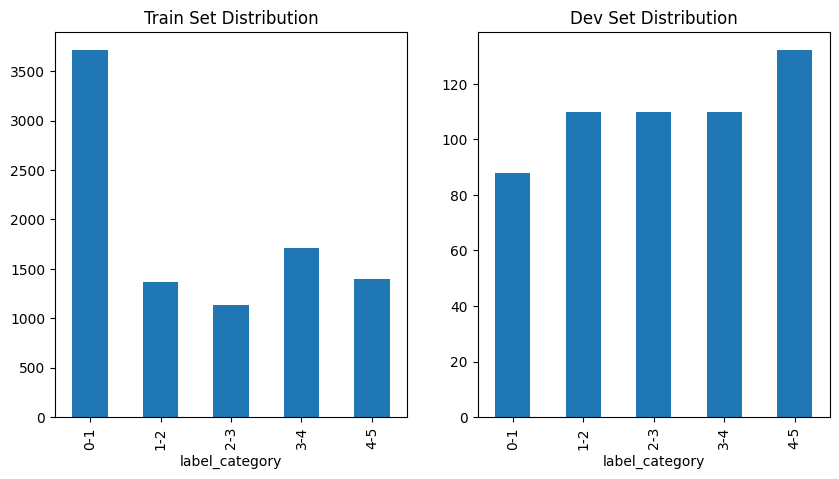

In [6]:
# 카테고리별 데이터 분포 시각화

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_data["label_category"].value_counts().sort_index().plot(
    kind="bar", title="Train Set Distribution"
)

plt.subplot(1, 2, 2)
dev_data["label_category"].value_counts().sort_index().plot(
    kind="bar", title="Dev Set Distribution"
)

plt.show()

#### **느낀 점**
- train set은 label 분포가 치우쳐있음
- dev set은 상대적으로 uniform하게 분포

### 2. Source Type별(rtt/sampled) 데이터 분포 확인

In [7]:
# ['source'] column에서 data type 추출
# source의 마지막이 rtt면 rtt, sampeld이면 sampled를 return

def classify_source(value):
    if value.endswith("rtt"):
        return "rtt"
    elif value.endswith("sampled"):
        return "sampled"
    else:
        return "unknown"

In [8]:
# 추출한 data type을 기준으로 dataset 분류

train_data["source_type"] = train_data["source"].apply(classify_source)
dev_data["source_type"] = dev_data["source"].apply(classify_source)

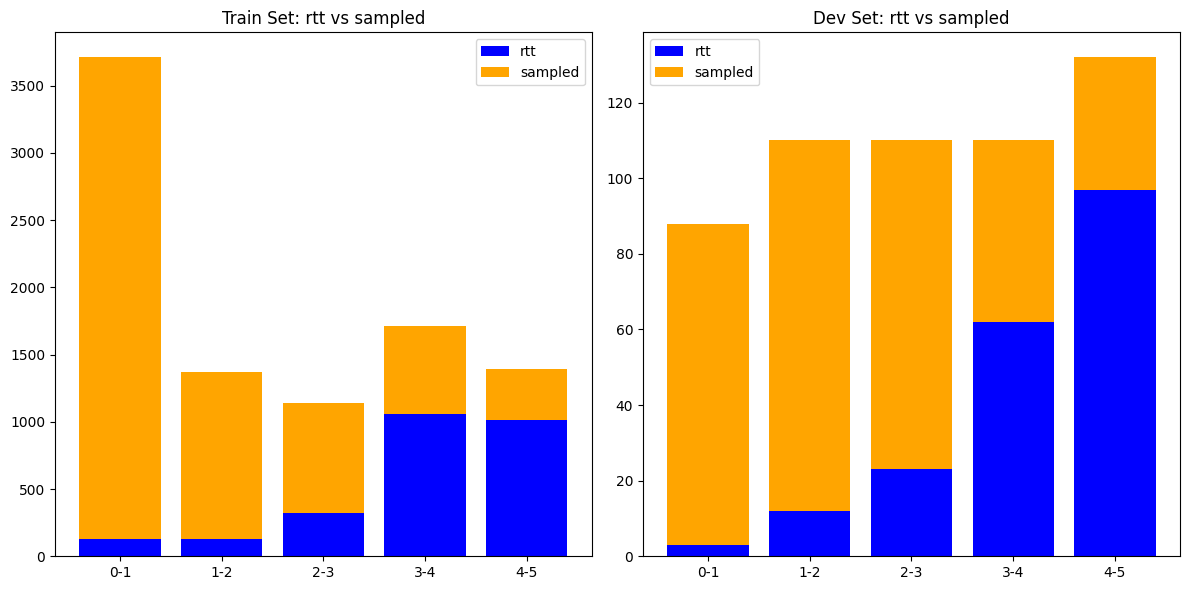

In [9]:
# source type별 label 분포 시각화

plt.figure(figsize=(12, 6))

# Train Set 분포
plt.subplot(1, 2, 1)
train_rtt = (
    train_data[train_data["source_type"] == "rtt"]["label_category"]
    .value_counts()
    .sort_index()
)
train_sampled = (
    train_data[train_data["source_type"] == "sampled"]["label_category"]
    .value_counts()
    .sort_index()
)

# stacked bar chart로 rtt는 아래, sampled는 위
plt.bar(train_rtt.index, train_rtt, label="rtt", color="blue")
plt.bar(
    train_sampled.index,
    train_sampled,
    bottom=train_rtt,
    label="sampled",
    color="orange",
)
plt.title("Train Set: rtt vs sampled")
plt.legend()

# Dev Set 분포
plt.subplot(1, 2, 2)
dev_rtt = (
    dev_data[dev_data["source_type"] == "rtt"]["label_category"]
    .value_counts()
    .sort_index()
)
dev_sampled = (
    dev_data[dev_data["source_type"] == "sampled"]["label_category"]
    .value_counts()
    .sort_index()
)

# stacked bar chart로 rtt는 아래, sampled는 위
plt.bar(dev_rtt.index, dev_rtt, label="rtt", color="blue")
plt.bar(dev_sampled.index, dev_sampled, bottom=dev_rtt, label="sampled", color="orange")
plt.title("Dev Set: rtt vs sampled")
plt.legend()

plt.tight_layout()
plt.show()

#### **느낀 점**
- train, dev 둘다 0~1, 1~2, 2~3은 sampled가 압도적으로 많다(특히 0~1)
- 3~4, 4~5를 target label로 가지는 데이터들은 대부분 rtt type의 데이터
- dev set에서 rtt 데이터 분포 먼가 웃김(브루마블에서 좋은 도시 위주로 차지한 느낌)

---

## Baseline Inference 결과 분석

모델이 어떤 상황에서 예측을 잘하고 못하는지 확인하기 위한 과정

### 1. Inference 결과로 Confusion Matrix 출력

In [12]:
# dev set 불러오기
df = pd.read_csv("../inference/output_with_predictions.csv")

# source 정보 추가 (dev.csv에서 가져오기)
dev_source = pd.read_csv("../raw/dev.csv")[["id", "source"]]
df = df.merge(dev_source, on="id", how="left")

df["source"] = df["source_x"]  # source_x를 그대로 사용
df = df.drop(columns=["source_x", "source_y"])  # 중복된 source_y 삭제

In [32]:
# 각 범위로 label과 predictions 분류
df["label_category"] = df["label"].apply(categorize)
df["prediction_category"] = df["predictions"].apply(categorize)

In [33]:
# Confusion matrix 생성
conf_matrix = confusion_matrix(
    df["label_category"], df["prediction_category"], labels=["0-1", "1-2", "2-3", "3-4", "4-5"]
)

In [34]:
# 잘못 예측한 데이터 찾기 (label과 predictions가 다른 경우)
df["is_incorrect"] = df["label_category"] != df["prediction_category"]

# 잘못된 예측 데이터 중 rtt와 sampled 개수 확인
incorrect_data = df[df["is_incorrect"]]

# source를 rtt / sampled로 분류
incorrect_data["source_type"] = incorrect_data["source"].apply(
    lambda x: "rtt" if x.endswith("rtt") else "sampled"
)

# rtt와 sampled 개수 확인
rtt_count = incorrect_data[incorrect_data["source_type"] == "rtt"].shape[0]
sampled_count = incorrect_data[incorrect_data["source_type"] == "sampled"].shape[0]

print(f"잘못된 예측 중 rtt 데이터 개수: {rtt_count}")
print(f"잘못된 예측 중 sampled 데이터 개수: {sampled_count}")

잘못된 예측 중 rtt 데이터 개수: 87
잘못된 예측 중 sampled 데이터 개수: 141


C:\Users\eyeol\AppData\Local\Temp\ipykernel_20312\2822804435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_data["source_type"] = incorrect_data["source"].apply(


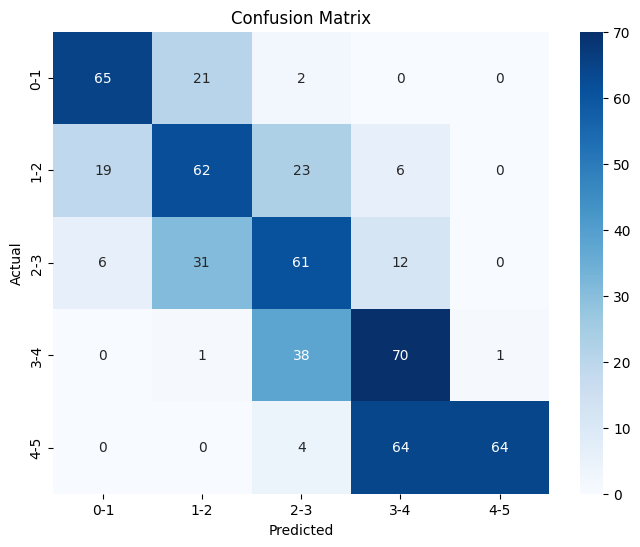

In [35]:
# Confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
    yticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### **느낀 점**
- rtt/sampled로 나눠서 confusion matrix를 출력해봐야겠다 </br>
  source type에 따라 예측 정확도가 달라지는지 확인하고 싶음

### 2. Source Type별(rtt/sampled) Confusion Matrix 출력

In [36]:
# source를 rtt / sampled로 분류
df["source_type"] = df["source"].apply(
    lambda x: "rtt" if x.endswith("rtt") else "sampled"
)

# rtt 데이터와 sampled 데이터로 분리
rtt_data = df[df["source_type"] == "rtt"]
sampled_data = df[df["source_type"] == "sampled"]

# Confusion matrix 생성
rtt_conf_matrix = confusion_matrix(
    rtt_data["label_category"],
    rtt_data["prediction_category"],
    labels=["0-1", "1-2", "2-3", "3-4", "4-5"],
)
sampled_conf_matrix = confusion_matrix(
    sampled_data["label_category"],
    sampled_data["prediction_category"],
    labels=["0-1", "1-2", "2-3", "3-4", "4-5"],
)

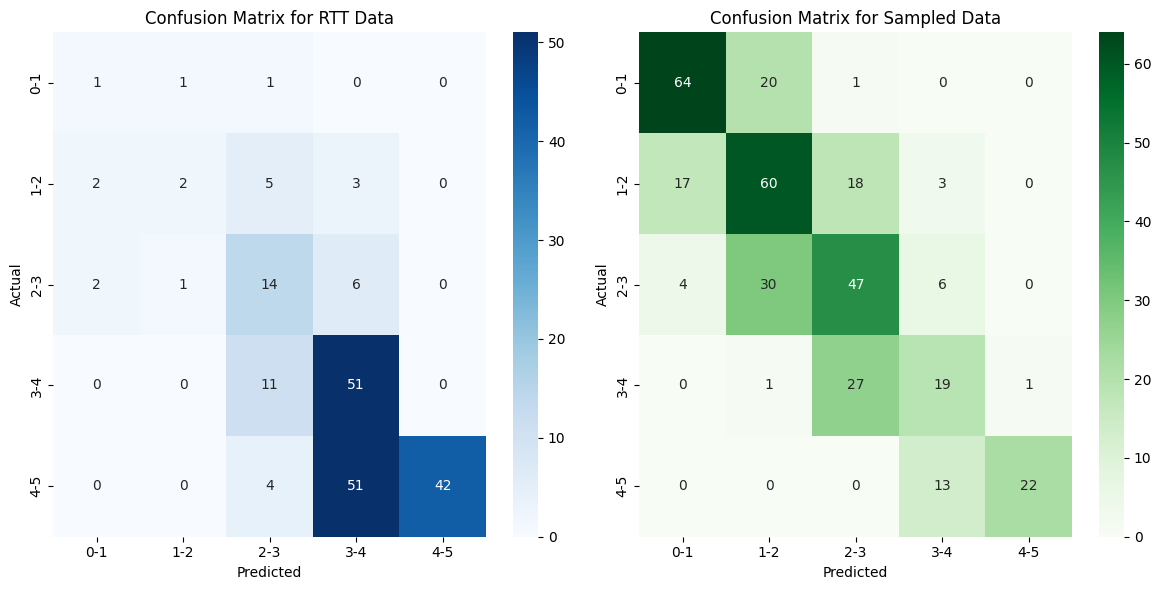

In [37]:
# Confusion matrix 시각화
plt.figure(figsize=(12, 6))

# rtt 데이터의 confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(
    rtt_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
    yticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
)
plt.title("Confusion Matrix for RTT Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# sampled 데이터의 confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(
    sampled_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
    yticklabels=["0-1", "1-2", "2-3", "3-4", "4-5"],
)
plt.title("Confusion Matrix for Sampled Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

#### **느낀 점**
- 해당 Confusion Matrix는 target과 predict의 차이를 정확하게 나타내지 못하고 있음 </br> </br>
  target이 3.9, predict가 4.1인 데이터는 예측이 정확한 편임에도 error처럼 표시되고 </br>
  target이 3.1, predict가 3.9인 데이터는 예측이 부정확한 편임에도 correct처럼 표시됨
</br></br>

- 따라서 target label과 predict label의 1의 자리로 표를 만드는게 아니라 </br>
  target과 predict의 차이인 label difference를 기준으로 만들어야 한다

### 3. Label Difference를 기준으로 Confusion Matrix 수정

정확도의 기준을 0.5로 정해두고(작성자가 임의로 정한 수치) </br>
label difference가 0.5 이상인 데이터들에 대해서만 Confusion Matrix를 출력해보자

In [73]:
## label_difference로 본 correct/error

# Target label과 predict label의 차이 계산
df['label_difference'] = abs(df['label'] - df['predictions'])

# 차이를 기준으로 데이터 분류
# 차이가 적은 데이터: difference < 0.5 (정확한 예측으로 간주)
correct_data = df[df['label_difference'] < 0.5]

# 차이가 큰 데이터: difference >= 0.5 (오차가 큰 데이터)
error_data = df[df['label_difference'] >= 0.5]

In [74]:
# 타겟 라벨 범위 생성 함수
def label_range(value):
    if np.isnan(value):
        return 'unknown'
    return f"{int(np.floor(value))}-{int(np.ceil(value))}"

In [75]:
# error_type을 완전히 대체하는 함수
def update_error_type(row):
    target_range = label_range(row['label'])
    prediction_range = label_range(row['predictions'])
    # 기존 error_type을 무시하고 새로운 {target range}_to_{prediction range}로 대체
    return f"{target_range}_to_{prediction_range}"

# error_type 열 업데이트
error_data['error_type'] = error_data.apply(update_error_type, axis=1)
correct_data['error_type'] = correct_data.apply(update_error_type, axis=1)

# 업데이트된 데이터 확인
print(error_data[['label', 'predictions', 'error_type']].head())
print(correct_data[['label', 'predictions', 'error_type']].head())

# 저장
#error_data_2.to_csv("./over05_error_with_replaced_ranges.csv", index=False)
#correct_data_2.to_csv("./under05_correct_with_replaced_ranges.csv", index=False)


   label  predictions  error_type
4    1.4          2.3  1-2_to_2-3
5    2.4          2.9  2-3_to_2-3
6    2.0          1.3  2-2_to_1-2
7    1.2          2.5  1-2_to_2-3
8    4.6          3.3  4-5_to_3-4
    label  predictions  error_type
0     2.0          1.6  2-2_to_1-2
1     3.4          3.3  3-4_to_3-4
2     4.0          3.6  4-4_to_3-4
3     3.4          3.1  3-4_to_3-4
10    3.4          3.1  3-4_to_3-4


C:\Users\eyeol\AppData\Local\Temp\ipykernel_20312\4139970949.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_data['error_type'] = error_data.apply(update_error_type, axis=1)
C:\Users\eyeol\AppData\Local\Temp\ipykernel_20312\4139970949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_data['error_type'] = correct_data.apply(update_error_type, axis=1)


In [76]:
## source / label 별로 정렬
error_data = error_data.sort_values(by=["source_type","error_type", "label_difference"])

correct_data = correct_data.sort_values(by=["source_type", "label"])

# error_data_2.to_csv("./over05_error.csv", index=False)
# correct_data_2.to_csv("./under05_correct.csv", index=False)

In [77]:
def extract_labels(error_type):
    target, predict = error_type.split('_to_')
    return target, predict

In [78]:
# error_data에 대해 target_label과 predict_label 생성
error_data[['target_label', 'predict_label']] = error_data['error_type'].apply(lambda x: pd.Series(extract_labels(x)))

# 구간 순서를 맞추기 위해 정렬 기준 리스트 생성
label_order = ['0-1', '1-2', '2-3', '3-4', '4-5']

In [79]:
error_data.head()

,id,sentence_1,sentence_2,label,binary-label,predictions,source,label_category,prediction_category,is_incorrect,source_type,label_difference,error_type,target_label,predict_label
28,boostcamp-sts-v1-dev-028,당연히 둘다 먹는거 아닌가요!,물론 둘 다 먹지는 않는다!,0.8,0.0,2.2,slack-rtt,0-1,2-3,True,rtt,1.4,0-1_to_2-3,0-1,2-3
208,boostcamp-sts-v1-dev-208,사대보험 개인별 납부실시,4대보험부과 산정시 개인 빚도 고려해 주세요.,1.8,0.0,0.5,petition-rtt,1-2,0-1,True,rtt,1.3,1-2_to_0-1,1-2,0-1
420,boostcamp-sts-v1-dev-420,아무래도 상관 없어요.,그것은 정말 중요하지 않습니다.,1.8,0.0,0.2,slack-rtt,1-2,0-1,True,rtt,1.6,1-2_to_0-1,1-2,0-1
423,boostcamp-sts-v1-dev-423,와. 너무너무 멋지네요. 클라임 업업!!,우와. 너무 좋아요. 올라가!!,1.6,0.0,2.1,slack-rtt,1-2,2-3,True,rtt,0.5,1-2_to_2-3,1-2,2-3
485,boostcamp-sts-v1-dev-485,함께 실험해보실분들 모두 환영입니다!,누구나 우리와 함께 실험할 수 있습니다!,1.6,0.0,2.3,slack-rtt,1-2,2-3,True,rtt,0.7,1-2_to_2-3,1-2,2-3


In [80]:
# RTT 데이터와 Sampled 데이터로 나누기
rtt_data = error_data[error_data['source_type'] == 'rtt']
sampled_data = error_data[error_data['source_type'] == 'sampled']

# RTT 데이터의 confusion matrix 생성
rtt_conf_matrix = pd.crosstab(rtt_data['target_label'], rtt_data['predict_label'], rownames=['Actual'], colnames=['Predicted']).reindex(index=label_order, columns=label_order, fill_value=0)

# Sampled 데이터의 confusion matrix 생성
sampled_conf_matrix = pd.crosstab(sampled_data['target_label'], sampled_data['predict_label'], rownames=['Actual'], colnames=['Predicted']).reindex(index=label_order, columns=label_order, fill_value=0)


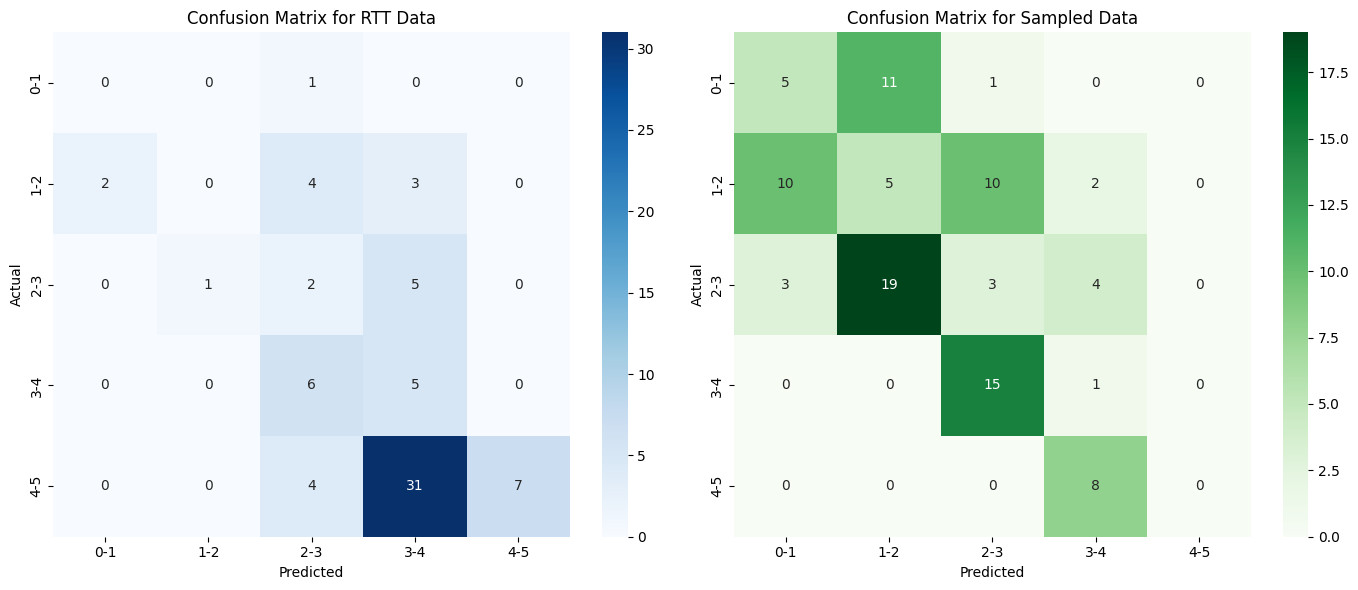

In [81]:
# 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# RTT Confusion Matrix
sns.heatmap(rtt_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix for RTT Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Sampled Confusion Matrix
sns.heatmap(sampled_conf_matrix, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Confusion Matrix for Sampled Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

#### **느낀 점**
- error data만 보이고 correct data는 나타내지 않았기 때문에 </br>
  Confusion Matrix라고 하기엔 좀 애매한 느낌?
</br></br>
- 그래도 앞서 만든 Confusion Matrix를 통해 전체 데이터 분포를 알고 있으니 </br>
  rtt와 sampled의 각 type별로 2개(총 4개)의 Matrix를 활용하면 될 것 같다